# Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, confusion_matrix

# Import Data

In [2]:
impt_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
import datetime

def d2(time_date):
    return(datetime.datetime.strptime(time_date, '%Y-%m-%d %H:%M:%S'))

def d1(time_date):
    return(datetime.datetime.strptime(time_date, '%Y-%m-%d %H:%M:%S'))

In [4]:
differences = [d2(time_date_1) - d1(time_date_2) for time_date_1, time_date_2 in zip(impt_data['listing_date'], impt_data['issue_date'])]
time_diff_col = pd.Series([(difference.days + difference.seconds/86400)/365.2425 for difference in differences]) 

In [5]:
differences = [d2(time_date_1) - d1(time_date_2) for time_date_1, time_date_2 in zip(test_data['listing_date'], test_data['issue_date'])]
time_diff_col_test = pd.Series([(difference.days + difference.seconds/86400)/365.2425 for difference in differences]) 

In [6]:
impt_data["year_diff"] = time_diff_col
test_data["year_diff"] = time_diff_col_test

# Pre Processing

In [7]:
impt_data.fillna(0, inplace = True)
test_data.fillna(0, inplace = True)

In [8]:
bc_labels_pd = impt_data.pop("breed_category")
pc_labels_pd = impt_data.pop("pet_category")

In [9]:
include_columns = ["condition", "color_type", "length(m)", "height(cm)", "X1", "X2", "year_diff"]
data_pd = impt_data[include_columns]
data_test_pd = test_data[include_columns]

In [10]:
# turn X into dict
data_dict = data_pd.to_dict(orient='records') # turn each row as key-value pairs
data_test_dict = data_test_pd.to_dict(orient='records') # turn each row as key-value pairs

In [11]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer
# instantiate a Dictvectorizer object for X
dv_X = DictVectorizer(sparse=False) 
# sparse = False makes the output is not a sparse matrix

# apply dv_X on X_dict
data = dv_X.fit_transform(data_dict)
X_test = dv_X.transform(data_test_dict)
# show X_encoded
X_test

array([[ 0.        ,  7.        ,  0.        , ..., 42.73      ,
         0.87      , 12.0595202 ],
       [ 0.        ,  1.        ,  0.        , ...,  6.71      ,
         0.06      ,  0.4783808 ],
       [ 0.        ,  7.        ,  0.        , ..., 41.21      ,
         0.24      ,  5.47499835],
       ...,
       [ 0.        ,  7.        ,  0.        , ..., 37.19      ,
         0.98      ,  1.07797293],
       [ 0.        ,  2.        ,  0.        , ..., 23.83      ,
         0.79      ,  1.06165957],
       [ 0.        ,  1.        ,  0.        , ..., 24.51      ,
         0.64      ,  1.07517418]])

In [12]:
# # Categorical boolean mask
# categorical_feature_mask = data_pd.dtypes==object

# # filter categorical columns using mask and turn it into a list
# categorical_cols = data_pd.columns[categorical_feature_mask].tolist()

In [13]:
# # instantiate labelencoder object
# le = LabelEncoder()

# # apply le on categorical feature columns
# data_pd[categorical_cols] = data_pd[categorical_cols].apply(lambda col: le.fit_transform(col))
# data_pd[categorical_cols].head(10)

# data_test_pd[categorical_cols] = data_test_pd[categorical_cols].apply(lambda col: le.fit_transform(col))
# data_test_pd[categorical_cols].head(10)

In [14]:
# data = data_pd.to_numpy()
# X_test = data_test_pd.to_numpy()
bc_labels = bc_labels_pd.to_numpy()
pc_labels = pc_labels_pd.to_numpy()
labels = np.stack((bc_labels, pc_labels), axis = -1)
print(data.shape)
print(X_test.shape)
print(pc_labels.shape)

(18834, 62)
(8072, 62)
(18834,)


# Train Test Split

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(data, bc_labels, random_state = 0, test_size = 0.3)

In [16]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.transform(np.expand_dims(Y_val, 1)).toarray()

C:\Users\Sriram Pingali\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [17]:
pc_labels

array([1, 2, 4, ..., 1, 2, 2], dtype=int64)

In [18]:
Y_OH_train[:40]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [19]:
X_train.shape

(13183, 62)

In [20]:
X_train, Y_OH_train, X_val, Y_OH_val, X_test = map(torch.tensor, (X_train, Y_OH_train, X_val, Y_OH_val, X_test))

In [21]:
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()

# Cuda Support

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

X_train = X_train.to(device)
X_val = X_val.to(device)
X_test  = X_test.to(device)
Y_OH_train = Y_OH_train.to(device)
Y_OH_val = Y_OH_val.to(device)

In [23]:
Y_OH_train.shape

torch.Size([13183, 3])

# FF Network

In [24]:
class FF_Network(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(62, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(128,512),
            nn.LeakyReLU(),
            nn.Linear(512, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 4)
        )
           
    def forward(self, X):
        return(self.net(X))

In [25]:
ff_n = FF_Network()
ff_n = ff_n.to(device)
loss_fn = nn.CrossEntropyLoss()

In [26]:
def accuracy(Y_hat, Y):
    accuracy = accuracy_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1))
    f1_scr = f1_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1), average='weighted')
    kappa = cohen_kappa_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1))
    return(accuracy, f1_scr, kappa)

In [27]:
def train(X, Y, model, loss_fn = loss_fn, lr = 0.02, epochs = 2500, batch_size = 512):
    loss_b = []
    acc_b = []
    acc = 0
    optm = optim.Adam(ff_n.parameters(), lr = lr)
    Y_temp = Y.to('cpu')
    Y = np.argmax(Y_temp, 1)
    Y = Y.to(device)
    for i in tqdm_notebook(range(epochs)):
        for i in range(X.shape[0] // batch_size):
            local_X, local_Y, local_y_temp = X[i*batch_size:(i+1)*batch_size,], Y[i*batch_size:(i+1)*batch_size,], Y_temp[i*batch_size:(i+1)*batch_size,]
            Y_hat = model.forward(local_X)
            loss = loss_fn(Y_hat, local_Y)
            acc, _, _ = accuracy(Y_hat, local_y_temp)
            loss_b.append(loss.item())
            acc_b.append(acc)
            loss.backward()
            optm.step()
            optm.zero_grad()
    return(loss_b, acc_b, acc)

In [28]:
%%time
loss_b, acc_b, acc_score = train(X_train, Y_OH_train, ff_n, loss_fn, lr = 0.001, epochs = 2500, batch_size = 8192)

C:\Users\Sriram Pingali\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Wall time: 4min 11s


Text(0, 0.5, 'acc')

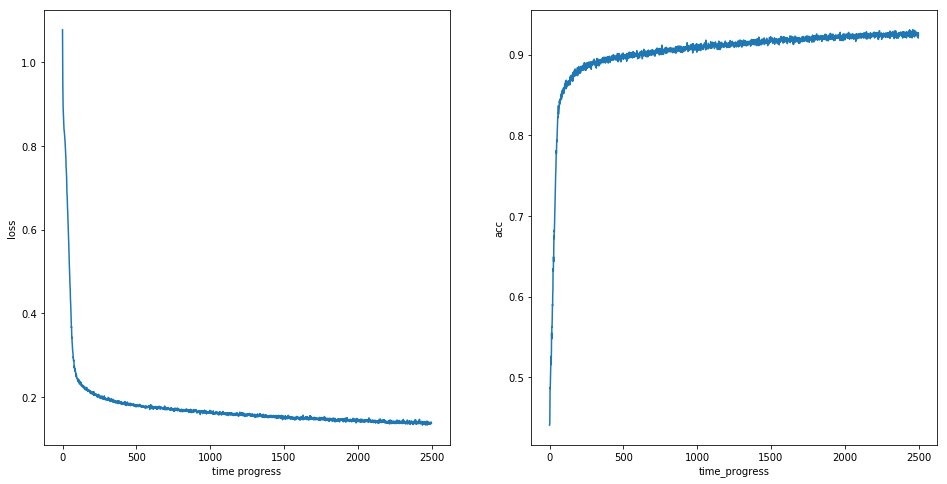

In [29]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(loss_b)
ax1.set_xlabel('time progress')
ax1.set_ylabel('loss')
ax2.plot(acc_b)
ax2.set_xlabel('time_progress')
ax2.set_ylabel('acc')

In [30]:
acc_b

[0.44091796875,
 0.44091796875,
 0.4432373046875,
 0.4744873046875,
 0.4874267578125,
 0.486083984375,
 0.4931640625,
 0.504150390625,
 0.508544921875,
 0.5159912109375,
 0.526123046875,
 0.515869140625,
 0.522216796875,
 0.5308837890625,
 0.55517578125,
 0.547607421875,
 0.5623779296875,
 0.5621337890625,
 0.568359375,
 0.579345703125,
 0.59033203125,
 0.5889892578125,
 0.6038818359375,
 0.6063232421875,
 0.631591796875,
 0.634765625,
 0.6317138671875,
 0.6494140625,
 0.6431884765625,
 0.6568603515625,
 0.675537109375,
 0.671875,
 0.682373046875,
 0.680419921875,
 0.6878662109375,
 0.6900634765625,
 0.7039794921875,
 0.7103271484375,
 0.719970703125,
 0.72802734375,
 0.7364501953125,
 0.74755859375,
 0.753173828125,
 0.7567138671875,
 0.7645263671875,
 0.7708740234375,
 0.78125,
 0.7774658203125,
 0.78759765625,
 0.7945556640625,
 0.7918701171875,
 0.7960205078125,
 0.802001953125,
 0.80810546875,
 0.8148193359375,
 0.8179931640625,
 0.8232421875,
 0.82177734375,
 0.8238525390625,
 0.

In [31]:
# ff_n.eval()
print("Train set accuracy, f1 score, kappa: ", accuracy(ff_n.forward(X_train), Y_OH_train), "\nValidation set accuracy, f1 score: ", accuracy(ff_n.forward(X_val), Y_OH_val))#, "\nTest set accuracy, f1 score: ", accuracy(ff_n.forward(X_test), Y_OH_test))

Train set accuracy, f1 score, kappa:  (0.9114769020708489, 0.9115174941781843, 0.8437922238189794) 
Validation set accuracy, f1 score:  (0.8798442753494957, 0.8798484656930208, 0.7889603269863691)


# Visual Evaluation

[[2371  281    0]
 [ 307 2191   48]
 [   0   67  386]]


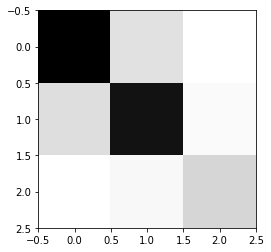

In [32]:
cm = confusion_matrix(np.argmax(Y_OH_val.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_val).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

[[5894  454    0]
 [ 594 5154   63]
 [   0   90  934]]


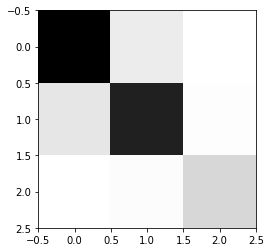

In [33]:
cm = confusion_matrix(np.argmax(Y_OH_train.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_train).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

# Saving Model

In [34]:
torch.save(ff_n.state_dict(), './weights')

In [35]:
model = FF_Network()
model.load_state_dict(torch.load('./weights'))
model.eval()
model.to(device)

FF_Network(
  (net): Sequential(
    (0): Linear(in_features=62, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=512, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=512, out_features=64, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [36]:
Y_test_pred = model.forward(X_test)

In [37]:
print("Train set Accuracy, F1 score, Cohen's Kappa: ", accuracy(model.forward(X_train), Y_OH_train), "\nValidation set Accuracy, F1 score, Cohens Kappa: ", accuracy(model.forward(X_val), Y_OH_val))

Train set Accuracy, F1 score, Cohen's Kappa:  (0.9205795342486536, 0.9205218011686296, 0.8599448300822321) 
Validation set Accuracy, F1 score, Cohens Kappa:  (0.8775437975579543, 0.8774607907090338, 0.7848906628439598)


In [38]:
import csv

with open('submission.csv', 'w', newline='') as file:
    with open('test.csv', 'r') as inp:
        writer = csv.writer(file)
        reader = csv.reader(inp)
        heading = next(reader)
        heading.append("class")
        writer.writerow(['class'])
        for i, row in enumerate(reader):
            writer.writerow(enc.inverse_transform(Y_test_pred.to('cpu').detach().numpy())[i])

In [39]:
file.close()
inp.close()

In [40]:
import os

name = 'answer.csv'
bakname = name + '.bak'
os.rename(name, bakname)

with open(bakname, 'rb') as csv_in, open(name, 'wb') as csv_out:
    writer = csv.writer(csv_out)
    for i, row in enumerate(csv.reader(csv_in)):
        row[2] = enc.inverse_transform(Y_test_pred.to('cpu').detach().numpy())[i]
        writer.writerow(row)